In [119]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zahid.Shaikh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
data1 = pd.read_json(r"C:\Users\Zahid.Shaikh\100days\92\Sarcasm_Headlines_Dataset.json\Sarcasm_Headlines_Dataset.json", lines=True)
data2 = pd.read_json(r"C:\Users\Zahid.Shaikh\100days\92\Sarcasm_Headlines_Dataset_v2.json\Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [39]:
data1 = data1[['headline','is_sarcastic']]
data2 = data2[['headline','is_sarcastic']]

data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)
data

headline  is_sarcastic
0      former versace store clerk sues over secret 'b...             0
1      the 'roseanne' revival catches up to our thorn...             0
2      mom starting to fear son's web series closest ...             1
3      boehner just wants wife to listen, not come up...             1
4      j.k. rowling wishes snape happy birthday in th...             0
...                                                  ...           ...
55323       jews to celebrate rosh hashasha or something             1
55324  internal affairs investigator disappointed con...             1
55325  the most beautiful acceptance speech this week...             0
55326  mars probe destroyed by orbiting spielberg-gat...             1
55327                 dad clarifies this not a food stop             1

[55328 rows x 2 columns]

In [40]:
print('-' * 100)
print("Rows: ", data.shape[0])
print("Columns: ", data.shape[1])
print('-' * 100)
print("Columns: \n", data.columns)
print('-' * 100)
print("Null Values: \n", data.isna().sum())
print('-' * 100)
print("Unique Values: \n", data.nunique())
print('-' * 100)
print("Info: ")
print(data.info())
print('-' * 100)

----------------------------------------------------------------------------------------------------
Rows:  55328
Columns:  2
----------------------------------------------------------------------------------------------------
Columns: 
 Index(['headline', 'is_sarcastic'], dtype='object')
----------------------------------------------------------------------------------------------------
Null Values: 
 headline        0
is_sarcastic    0
dtype: int64
----------------------------------------------------------------------------------------------------
Unique Values: 
 headline        28503
is_sarcastic        2
dtype: int64
----------------------------------------------------------------------------------------------------
Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non

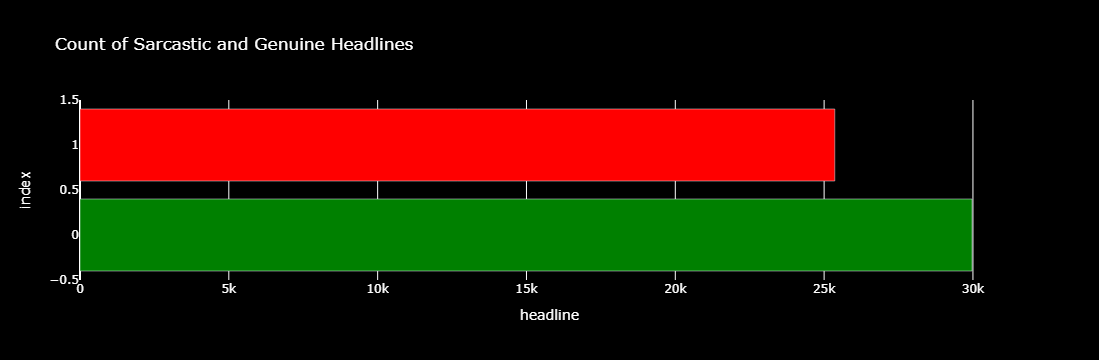

In [41]:
fig = px.bar(data.groupby('is_sarcastic').count().reset_index(), x='headline', title='Count of Sarcastic and Genuine Headlines')

fig.update_layout(
    plot_bgcolor='black',  
    paper_bgcolor='black',  
    font_color='white'  
)

fig.update_traces(marker_color=['green', 'red'])

fig.show()

In [42]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):
    
    headline = re.sub(r'\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

In [43]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|██████████| 55328/55328 [08:40<00:00, 106.31it/s]


In [79]:
data_1 = data.copy()

In [80]:
data_1['clean_headline'] = data_1['headline'].apply(text_cleaning)
data_1['sentence_length'] = data_1['clean_headline'].apply(lambda x: len(x.split()))
data_1

headline  is_sarcastic  \
0      former versace store clerk sues over secret 'b...             0   
1      the 'roseanne' revival catches up to our thorn...             0   
2      mom starting to fear son's web series closest ...             1   
3      boehner just wants wife to listen, not come up...             1   
4      j.k. rowling wishes snape happy birthday in th...             0   
...                                                  ...           ...   
55323       jews to celebrate rosh hashasha or something             1   
55324  internal affairs investigator disappointed con...             1   
55325  the most beautiful acceptance speech this week...             0   
55326  mars probe destroyed by orbiting spielberg-gat...             1   
55327                 dad clarifies this not a food stop             1   

          entity                                     clean_headline  \
0                 former versace store clerk sue secret black co...   
1                 roseanne revival catch thorny political mood b...   
2                 mom start fear son web series closest thing gr...   
3            ORG  boehner want wife listen not come alternative ...   
4         PERSON  j k rowling wish snape happy birthday magical way   
...          ...                                                ...   
55323        ORG             jews celebrate rosh hashasha something   
55324        ORG  internal affairs investigator disappoint consp...   
55325  DATE,NORP  beautiful acceptance speech week come queer ko...   
55326     PERSON  mar probe destroy orbit spielberg gate space p...   
55327                                     dad clarify not food stop   

       sentence_length  
0                   10  
1                    8  
2                    9  
3                   10  
4                    9  
...                ...  
55323                5  
55324                8  
55325                7  
55326                8  
55327                5  

[55328 rows x 5 columns]

In [81]:
fig = px.histogram(data_1, 
                   x="sentence_length", 
                   height=700, 
                   color='is_sarcastic', 
                   title="Headlines Length Distribution", 
                   marginal="box", 
                   color_discrete_map={'True': 'green', 'False': 'red'})  

fig.update_layout(
    plot_bgcolor='black',   
    paper_bgcolor='black',  
    font=dict(color='white')  
)

fig.show()


In [82]:
data_1[data_1['sentence_length'] == 107]['headline']

34011    hot wheels ranked number one toy for rolling d...
Name: headline, dtype: object

In [83]:
data_1.drop(data_1[data_1['sentence_length'] == 107].index, inplace = True)
data_1.reset_index(inplace=True, drop=True)

In [84]:
fig = px.histogram(data_1, 
                   x="sentence_length", 
                   height=700, 
                   color='is_sarcastic', 
                   title="Headlines Length Distribution", 
                   marginal="box", 
                   color_discrete_map={'True': 'green', 'False': 'red'})  

fig.update_layout(
    plot_bgcolor='black',   
    paper_bgcolor='black',  
    font=dict(color='white')  
)

fig.show()


In [85]:
data_1['contains_number'] = data_1['clean_headline'].apply(lambda x: bool(re.search(r'\d+', x)))
data_1

headline  is_sarcastic  \
0      former versace store clerk sues over secret 'b...             0   
1      the 'roseanne' revival catches up to our thorn...             0   
2      mom starting to fear son's web series closest ...             1   
3      boehner just wants wife to listen, not come up...             1   
4      j.k. rowling wishes snape happy birthday in th...             0   
...                                                  ...           ...   
55322       jews to celebrate rosh hashasha or something             1   
55323  internal affairs investigator disappointed con...             1   
55324  the most beautiful acceptance speech this week...             0   
55325  mars probe destroyed by orbiting spielberg-gat...             1   
55326                 dad clarifies this not a food stop             1   

          entity                                     clean_headline  \
0                 former versace store clerk sue secret black co...   
1                 roseanne revival catch thorny political mood b...   
2                 mom start fear son web series closest thing gr...   
3            ORG  boehner want wife listen not come alternative ...   
4         PERSON  j k rowling wish snape happy birthday magical way   
...          ...                                                ...   
55322        ORG             jews celebrate rosh hashasha something   
55323        ORG  internal affairs investigator disappoint consp...   
55324  DATE,NORP  beautiful acceptance speech week come queer ko...   
55325     PERSON  mar probe destroy orbit spielberg gate space p...   
55326                                     dad clarify not food stop   

       sentence_length  contains_number  
0                   10            False  
1                    8            False  
2                    9            False  
3                   10            False  
4                    9            False  
...                ...              ...  
55322                5            False  
55323                8            False  
55324                7            False  
55325                8            False  
55326                5            False  

[55327 rows x 6 columns]

In [86]:
sarcastic = data_1[data_1['is_sarcastic']==1]['clean_headline'].tolist()
genuine = data_1[data_1['is_sarcastic']==0]['clean_headline'].tolist()

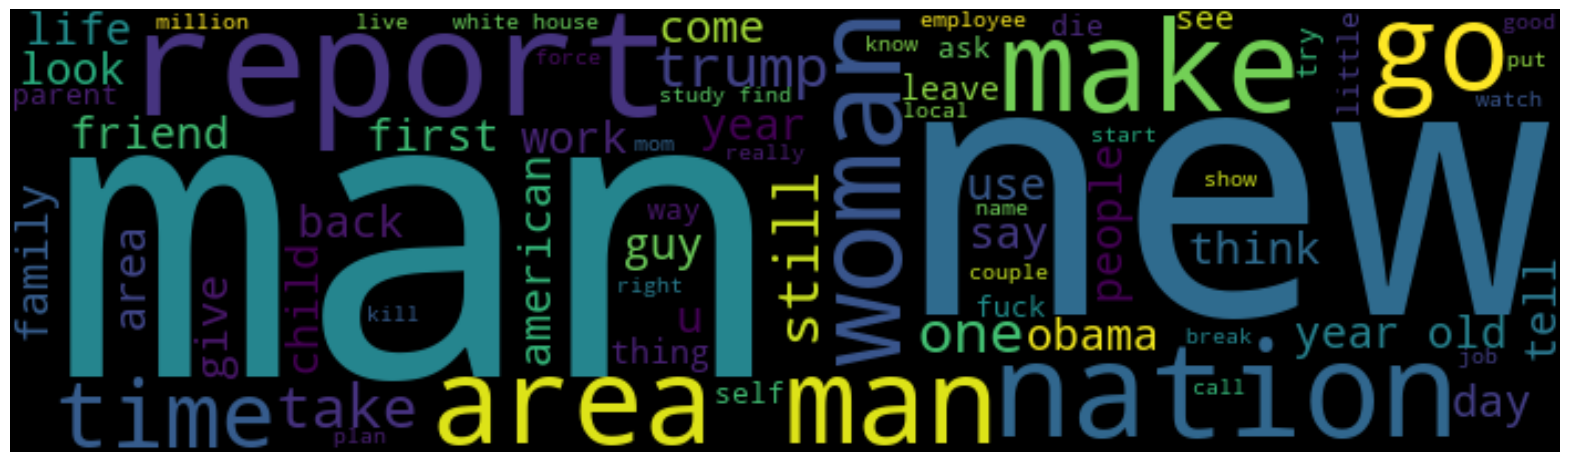

In [87]:
wordcloud = WordCloud(max_words=70, width=700, background_color='black').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

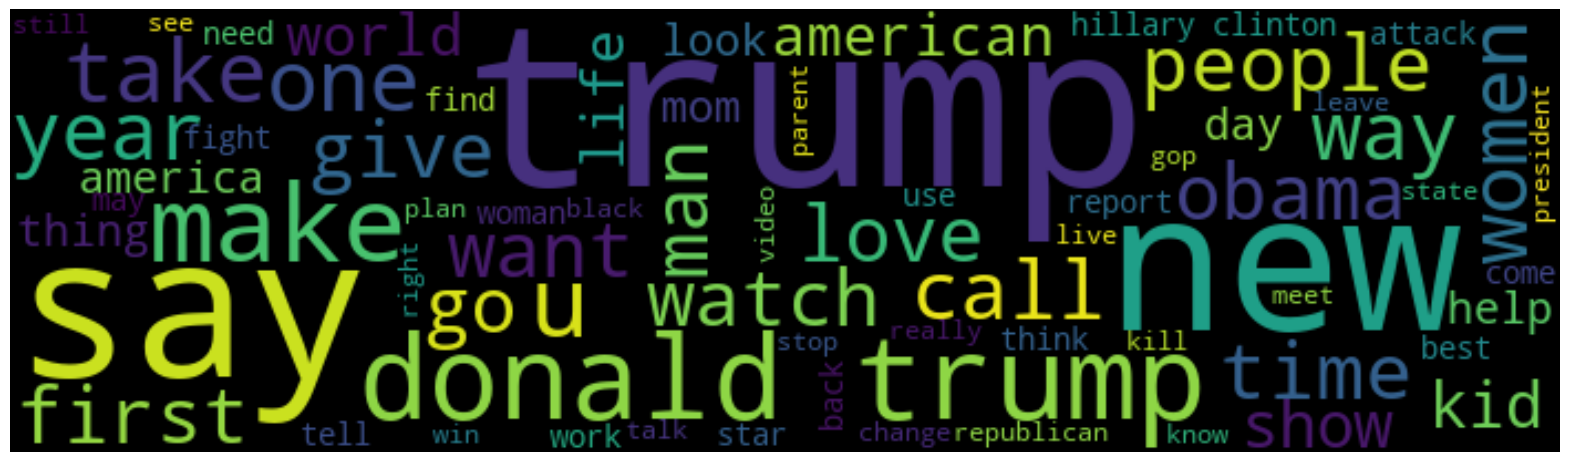

In [88]:
wordcloud = WordCloud(max_words=70, width=700, background_color='black').generate(" ".join(genuine))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
sentences = data_1['clean_headline']
label = data_1['is_sarcastic']

In [90]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [91]:
max_len = 20       
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  20938


In [92]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [98]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training=False):  
        # Ensure the attention layer receives query, key, and value as inputs
        attn_output = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [104]:
embed_dim = 50  
heads = 2  
neurons = 32
maxlen = 20
vocab_size = 20938

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [105]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_5  │ (None, 20, 50)         │     1,047,900 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_5           │ (None, 20, 50)         │        23,832 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,071,783 (4.09 MB)

 Trainable params: 1,071,783 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [107]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/25
1383/1384 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6757 - loss: 0.5726
Epoch 1: val_loss improved from inf to 0.33230, saving model to model.keras
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.6759 - loss: 0.5725 - val_accuracy: 0.8572 - val_loss: 0.3323 - learning_rate: 3.0000e-04
Epoch 2/25
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9015 - loss: 0.2452
Epoch 2: val_loss improved from 0.33230 to 0.27009, saving model to model.keras
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.9015 - loss: 0.2452 - val_accuracy: 0.8914 - val_loss: 0.2701 - learning_rate: 3.0000e-04
Epoch 3/25
1383/1384 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9450 - loss: 0.1512
Epoch 3: val_loss improved from 0.27009 to 0.22397, saving model to model.keras
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9450 - loss: 0.1512 - val_accuracy: 0.9210 - val_loss: 0.2240 - learning_rate: 3.0000e-04
Epoch 4/25
1383/1384 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/

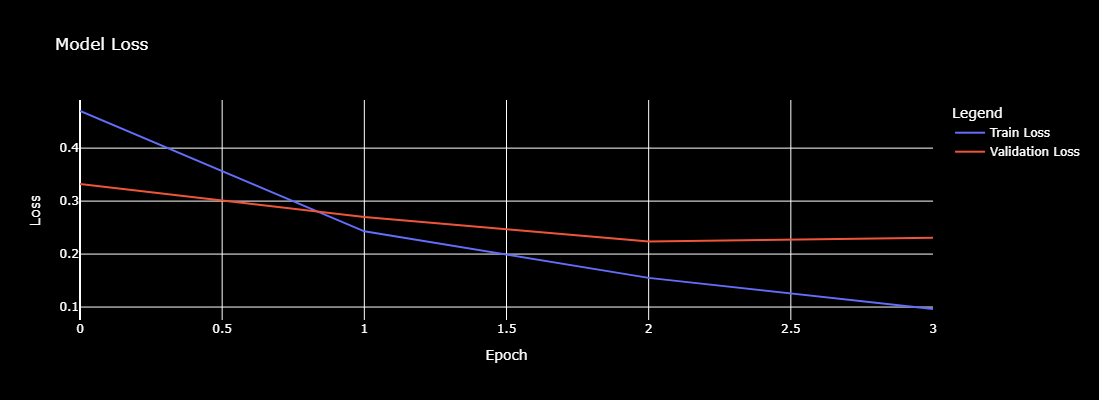

In [109]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history.history['loss'],
    mode='lines',
    name='Train Loss'
))

fig.add_trace(go.Scatter(
    y=history.history['val_loss'],
    mode='lines',
    name='Validation Loss'
))

fig.update_layout(
    title='Model Loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    legend_title='Legend',
    width=1000,  
    height=400,  
    plot_bgcolor='black',  
    paper_bgcolor='black', 
    font=dict(color='white') 
)

fig.show()

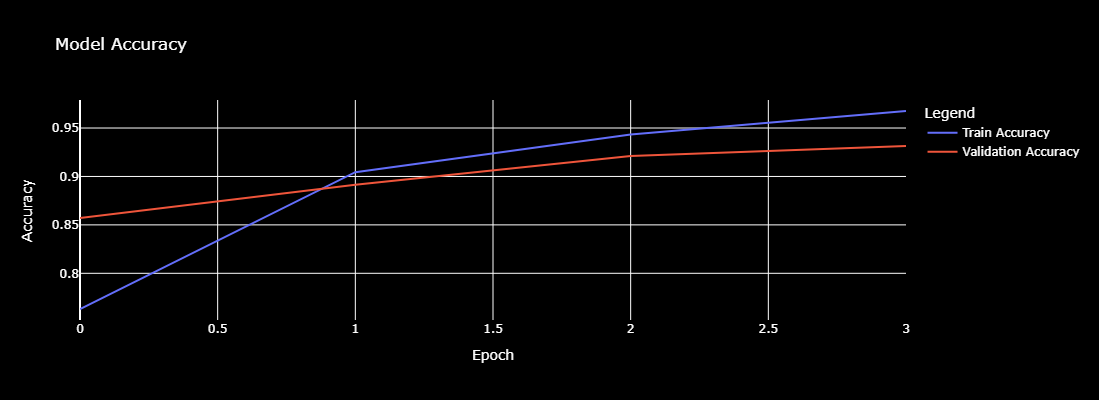

In [110]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history.history['accuracy'],
    mode='lines',
    name='Train Accuracy'
))

fig.add_trace(go.Scatter(
    y=history.history['val_accuracy'],
    mode='lines',
    name='Validation Accuracy'
))

fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    legend_title='Legend',
    width=1000,  
    height=400,  
    plot_bgcolor='black', 
    paper_bgcolor='black',
    font=dict(color='white')
)

fig.show()

In [113]:
y_pred = model.predict(X_test)

y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2997
           1       0.97      0.88      0.92      2536

    accuracy                           0.93      5533
   macro avg       0.93      0.93      0.93      5533
weighted avg       0.93      0.93      0.93      5533



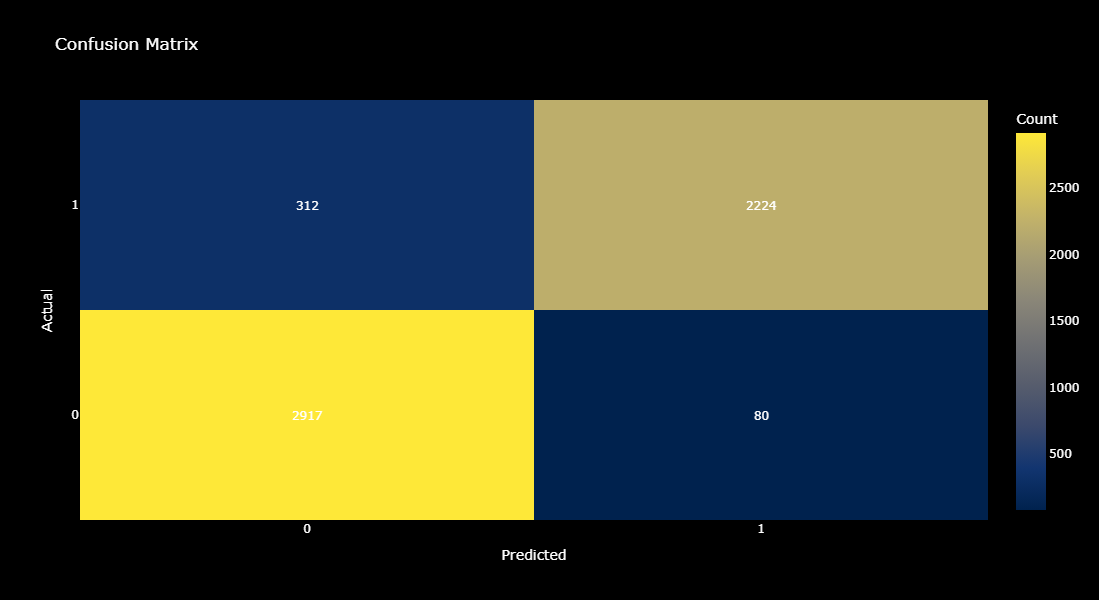

In [118]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig = go.Figure(
    data=go.Heatmap(
        z=conf_matrix,
        colorscale='Cividis',  
        colorbar=dict(title='Count'),
        text=np.array(conf_matrix, dtype=str),
        hoverinfo="text+z"
    )
)

annotations = []
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annotations.append(
            dict(
                x=j,
                y=i,
                text=str(conf_matrix[i][j]),
                showarrow=False,
                font=dict(color='white')
            )
        )

fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted', tickmode='linear'),
    yaxis=dict(title='Actual', tickmode='linear'),
    width=800,  
    height=600, 
    plot_bgcolor='black',  
    paper_bgcolor='black',  
    font=dict(color='white'),
    annotations=annotations
)

fig.show()